# 15-688 Final Project: Text Analysis of Yelp Reviews

### Xinpeng Zheng (xinpengz) & Yiling Zhong (yzhong1)

In [1]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.4-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark import SparkConf, SparkContext
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.mllib.regression import LabeledPoint
import matplotlib.pyplot as plt
import json
from pyspark import SparkConf, SparkContext
import collections
import ast
import numpy as np

### In this project, we will be using a library called pyspark. http://spark.apache.org/docs/2.2.0/api/python/pyspark.html pyspark can be used to implement distributed data management and machine learning.

Pyspark can be used to process large volume of data (sciklearn is useful too but will not scale well). For the purpose of this assignment, our dataset is limited in size. We tried to collect a larger dataset, but our scraping method was too slow. However, in real practice, there are billions of data on Yelp and we need to consider scalability. The data collection process and code is in the appendix at the end of this notebook. 

In [40]:
## Transform the data from json into rdd. The data collection and tranformation into json is in the scrape notebook. 
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents)
    return rdd

reviews = get_rdd_from_path('reviews.json')
print(reviews.count())
print(reviews.take(1))

4600
[{'business_id': 'u4sTiCzVeIHZY8OlaL346Q', 'date': '4/28/2018', 'name': 'Christy', 'rating': '5.0', 'review_id': 'qKznNGIhYpFVcmRv-ng5zA', 'text': "Our absolute favorite place to eat in Pittsburgh. Always worth the long wait in line. Some of the best chimichurri you'll ever have- do yourself a favor and get some extra toast just to dip in the sauces. I recommend the Asado Platter- good to split between 4 people when you order lots of sides! The empanadas are also great, but they do sometimes run out before the end of the night, so try to get there before then! 10/10 highly recommend. Great food at a reasonable price considering the quality & quantity. Be sure to bring your own wine or beer!", 'user_id': 'KcHfZCMMO5jU4p9rYlVxEA', 'votes': "{'useful': 0.0, 'funny': 0.0, 'cool': 0.0}"}]


The dataset reviews contains information about business reviews written by users on Yelp. Each review's data is stored as a Python dictionary. The dictionary consists of the following fields:

*  "review_id" : encrypted review id
*  "user_id" : encrypted user id
*  "business_id" : encrypted business id
*  "rating" : star rating rounded to half-stars
*  "text" : review text
*  "useful" : number of useful votes received
*  "funny" : number of funny votes received
*  "cool" : number of cool review votes received

# Descriptive Analysis

We want to see if users are more willing to give out good reviews. As we can see, the average ratings a user gives out is 4.28 stars in our dataset. Most reviews are positive. 

4.282826086956522


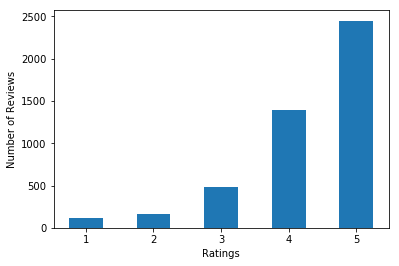

In [37]:
review_rating_counts = reviews.map(lambda x: float(x['rating'])).collect()
print(sum(review_rating_counts)/len(review_rating_counts))
plt.hist(review_rating_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Ratings')
plt.ylabel('Number of Reviews')
plt.show()

Also, most users are not frequent reviewers. The average user has submitted one review. 

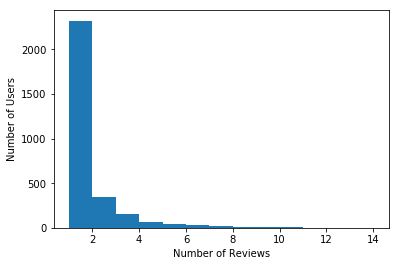

In [19]:
user_review_counts = list(reviews.map(lambda x : x['user_id']).countByValue().values())
plt.hist(user_review_counts, bins=[x for x in range(1, 15)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')
plt.show()

Other users can vote on the usefulness, funniness, and coolness of a review. The following graph plots the histogram of useful votes reviews have. 

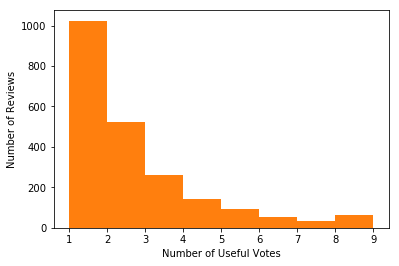

In [24]:
review_useful_counts = reviews.map(lambda x : ast.literal_eval(x['votes'])['useful']).collect()

plt.hist(review_useful_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')
plt.show()

We wanted to see if male and female users have different behavior when writing reviews. First we extract, based on first name, the gender user an unique ids is linked to. We then seprated reviews into reviews by male users, and reviews by female users. 

In [25]:
# helper function to load a list of names, thanks to Abhinav Maurya
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/pylon5/ci5619p/ahmaurya/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/pylon5/ci5619p/ahmaurya/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


In [26]:
male_users = reviews.filter(lambda x : x['name'] in male_names)
female_users = reviews.filter(lambda x : x['name'] in female_names)

male_user_ids = male_users.map(lambda x : x['user_id']).collect()
female_user_ids = female_users.map(lambda x : x['user_id']).collect()

We calculate the average review length for both genders. 

In [33]:
male_reviews = reviews.filter(lambda x : x['user_id'] in male_user_ids ).map(lambda x : x['text'])
female_reviews = reviews.filter(lambda x : x['user_id'] in female_user_ids ).map(lambda x : x['text'])
male_word_count = male_reviews.map(lambda x : len(x))
female_word_count = female_reviews.map(lambda x : len(x))

print ('Male and female review length averages: ', male_word_count.mean(),female_word_count.mean())

Male and female review length averages:  666.4636258660504 737.6032282282295


The following is a histogram of review words length. From this we can see that women are more likely to write reviews, and to write longer reviews compared with men in our dataset. 

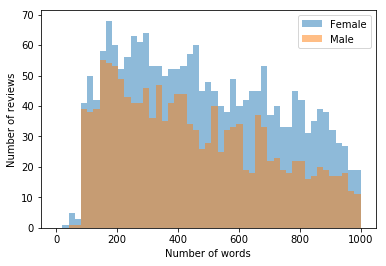

In [34]:
female_reviews_length = female_word_count.collect()
male_reviews_length = male_word_count.collect()

bins = np.linspace(0, 1000)

plt.hist(female_reviews_length, bins, alpha=0.5, label = 'Female')
plt.hist(male_reviews_length, bins, alpha=0.5, label = 'Male')
plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()
plt.show()

## Prediction of votes using tree ensemble methods

#### Under each review, there are vote buttons for funny,useful or cool. Users can use these vote on the reviews of others. Utilizing the classification method, we can identify what kind of reviews are the most useful to users, based on user generated votes Featuring reviews mostly likely to be useful on the top of the page will help people find good reviews easier. 

![funny_vote.png](attachment:funny_vote.png)

In [69]:
max_words = 50000

all_reviews = reviews.map(lambda x : (x['text'], ast.literal_eval(x['votes'])['useful']))
print(all_reviews.take(1))
word_counts = list(all_reviews.flatMap(lambda x : x[0].split(" ")).map(lambda x: (x,1)).countByKey().items())
print(word_counts[0])
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)


[("Our absolute favorite place to eat in Pittsburgh. Always worth the long wait in line. Some of the best chimichurri you'll ever have- do yourself a favor and get some extra toast just to dip in the sauces. I recommend the Asado Platter- good to split between 4 people when you order lots of sides! The empanadas are also great, but they do sometimes run out before the end of the night, so try to get there before then! 10/10 highly recommend. Great food at a reasonable price considering the quality & quantity. Be sure to bring your own wine or beer!", 0.0)]
('Our', 283)
Number of unique words:  42003


In [70]:
word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

In [71]:
longest_review_len = all_reviews.map(lambda x: len([w for w in x[0].split() if w in word_to_index_dict]))\
                                .max()
def gen_features(words):
    result = np.zeros(longest_review_len) - 1
    valid_words = [word_to_index_dict[w] for w in words if w in word_to_index_dict]
    result[:len(valid_words)] = valid_words
    return result
doc_vectors = all_reviews.map(lambda x: (x[1], x[0].split()))\
                         .map(lambda x: LabeledPoint(x[0], gen_features(x[1])))

In [72]:
#Split the data into train and test
doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit([0.8,0.2], seed=244)

Baseline prediction

In [73]:
##Get a baseline prediction
most_common_prediction = doc_vectors_train.map(lambda x : (x.label,1)).reduceByKey(lambda x,y : x+y)\
                                          .map(lambda x : x[1]).takeOrdered(1, key = lambda x: -x)[0]
#print(most_common_prediction)
labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 3400866.7098623854
Learned baseline prediction:  1846


#### Let us now use a Decision Tree to predict the number of useful votes. As we are using regression, the impurity measurement is set to variance

In [74]:
dt_model = DecisionTree.trainRegressor(doc_vectors_train,categoricalFeaturesInfo={},impurity='variance', maxDepth=5)

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

Validation Root Mean Squared Error (Decision Tree) = 81.48954456179776
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 49 nodes
  If (feature 141 <= 0.5)
   If (feature 112 <= 830.0)
    If (feature 57 <= 0.5)
     If (feature 13 <= 7327.0)
      If (feature 3 <= 1607.5)
       Predict: 0.40309155766944116
      Else (feature 3 > 1607.5)
       Predict: 0.7802197802197802
     Else (feature 13 > 7327.0)
      If (feature 31 <= 5683.0)
       Predict: 0.6610169491525424
      Else (feature 31 > 5683.0)
       Predict: 14.25
    Else (feature 57 > 0.5)
     If (feature 46 <= 18648.5)
      If (feature 80 <= 2639.0)
       Predict: 0.9237668161434978
      Else (feature 80 > 2639.0)
       Predict: 1.793103448275862
     Else (feature 46 > 18648.5)
      If (feature 58 <= -0.5)
       Predict: 43.0
      Else (feature 58 > -0.5)
       Predict: 1.8703703703703705
   Else (feature 112 > 830.0)
    If (feature 75 <= 0.5)
     If (feature 0 <= 962.0)
      If (feat

#### Let us now use a Random Forest ensemble to predict the number of useful votes. We set the maximum depth of the tree to 5 and variance impurity for regression.

In [75]:
rf_model = RandomForest.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={},
                                    numTrees=10,impurity='variance', maxDepth=5)

predictions = rf_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Random Forest) = ' + str(val_mse))
print('Learned regression RF model:')
print(rf_model.toDebugString())

Validation Root Mean Squared Error (Random Forest) = 93.10123414875125
Learned regression RF model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 206 <= 6.5)
     If (feature 99 <= 3.5)
      If (feature 46 <= 18648.5)
       If (feature 186 <= 209.5)
        If (feature 52 <= 0.5)
         Predict: 0.48264984227129337
        Else (feature 52 > 0.5)
         Predict: 0.8271983640081799
       Else (feature 186 > 209.5)
        If (feature 73 <= 5.5)
         Predict: 10.5
        Else (feature 73 > 5.5)
         Predict: 2.375
      Else (feature 46 > 18648.5)
       If (feature 38 <= 1.5)
        If (feature 8 <= 1.5)
         Predict: 43.0
        Else (feature 8 > 1.5)
         Predict: 1.0
       Else (feature 38 > 1.5)
        If (feature 7 <= 0.5)
         Predict: 22.0
        Else (feature 7 > 0.5)
         Predict: 0.8936170212765957
     Else (feature 99 > 3.5)
      If (feature 21 <= 23632.5)
       If (feature 542 <= 160.5)
        If (feature 37 <= 

#### We then use a Gradient Boosting Trees (GBT) ensemble to predict the number of user votes. The idea of gradient boosted trees is to iteratively train a decision tree of fixed size to residuals from the previous iteration. 

In [76]:
gb_model = GradientBoostedTrees.trainRegressor(doc_vectors_train,categoricalFeaturesInfo={}, numIterations=10)

predictions = gb_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Gradient Boosting Trees) = ' + str(val_mse))
print('Learned regression GBT model:')
print(gb_model.toDebugString())

Validation Root Mean Squared Error (Gradient Boosting Trees) = 77.95519902150733
Learned regression GBT model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 141 <= 0.5)
     If (feature 112 <= 830.0)
      If (feature 57 <= 0.5)
       Predict: 0.5313075506445673
      Else (feature 57 > 0.5)
       Predict: 1.0746500777604977
     Else (feature 112 > 830.0)
      If (feature 75 <= 0.5)
       Predict: 36.0
      Else (feature 75 > 0.5)
       Predict: 1.9833333333333334
    Else (feature 141 > 0.5)
     If (feature 607 <= 6875.5)
      If (feature 16 <= 21427.0)
       Predict: 3.1588235294117646
      Else (feature 16 > 21427.0)
       Predict: 10.575
     Else (feature 607 > 6875.5)
      If (feature 1 <= 30.5)
       Predict: 49.0
      Else (feature 1 > 30.5)
       Predict: 22.5
  Tree 1:
    If (feature 276 <= 30.5)
     If (feature 156 <= 5.5)
      If (feature 144 <= 4784.5)
       Predict: -0.1285660133648345
      Else (feature 144 > 4784.5)
       Pre

#### As we can see, gradient boosting decision tree yields the best result in this case.(lowest RMSE) We can use models like this to predict how useful new reviews. This is useful as websites can feature more useful reviews first. 

## Collaborative Filtering 

We use a collaborative filtering model which can be used to recommend businesses to users based on the ratings they have already given to some businesses they have visited. We start by determining the unique user and business IDs that appear in the reviews data. This will help us build dictionaries for mapping the user/business IDs to unique integer indices.

In [8]:
review_user_ids = reviews.map(lambda x : x['user_id']).collect()
review_business_ids = reviews.map(lambda x : x['business_id']).collect()

user_to_index_dict = { review_user_ids[i] : i for i in range(len(review_user_ids))}
business_to_index_dict = { review_business_ids[i] : i for i in range(len(review_business_ids))}

We then created a ratings object that transforms each review into a rating.

In [11]:
ratings = reviews.map(lambda x: Rating(user_to_index_dict[x['user_id']],\
                                               business_to_index_dict[x['business_id']]\
                                               ,float(x['rating']) ))
ratings_train, ratings_val = ratings.randomSplit([0.8,0.2], seed=244)

For a succession of ranks, we will now build an collaborative filtering algorithm using Alternating Least Squares model, obtaining training and validation RMSE for each rank.

In [13]:
numIterations=10
ranks = list(range(1,20)) + list(range(20, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings_train, rank, numIterations)
    
    train_data = ratings_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

Root Mean Squared Error (rank=1) = Train 2.2303403608067565, Validation 7.04878694620772
Root Mean Squared Error (rank=2) = Train 1.533144555837993, Validation 6.239180193329855
Root Mean Squared Error (rank=3) = Train 0.7844573191101099, Validation 6.37091414971995
Root Mean Squared Error (rank=4) = Train 0.2767073821956983, Validation 3.088752464421239
Root Mean Squared Error (rank=5) = Train 0.20211444473213522, Validation 3.957891788882398
Root Mean Squared Error (rank=6) = Train 0.10384699429927943, Validation 2.908178527080322
Root Mean Squared Error (rank=7) = Train 0.0684117498859423, Validation 3.84174247060158
Root Mean Squared Error (rank=8) = Train 0.048531503337014996, Validation 4.471769560371197
Root Mean Squared Error (rank=9) = Train 0.03920853406675996, Validation 3.9159862099832474
Root Mean Squared Error (rank=10) = Train 0.02761695914017061, Validation 4.0740106338454085
Root Mean Squared Error (rank=11) = Train 0.01938075153961597, Validation 3.900621171534686
Roo

Ploting the train and validation RMSE versus the rank, we would select rank at around 55 which gives a smaller MSE and does not overcomplicate the model. 

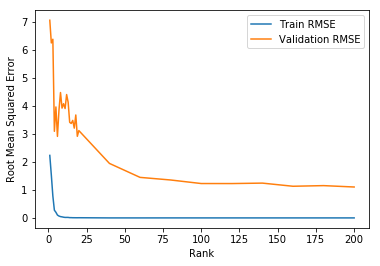

In [14]:
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

## Topic Modeling 

Large volume of reviews can help us to discover people who like similar topics. If we can find similar people,then we might be able to do cross recommendation: push restaurants of people who are simiar to you. 

#### Method1: In this section, we will explore how to model topics using LDA (Latent Dirichlet allocation). https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation 

In [77]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.clustering import LDA, LDAModel

In [78]:
# remove most frequent words/stop words 
num_stop_words = 1000

all_reviews = reviews_rdd.map(lambda x : (x['text']))
word_counts = list(all_reviews.flatMap(lambda x: x.lower().split()).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key = lambda x : -x[1]) 

# remove stopwords
unique_words = [x[0] for x in word_counts[num_stop_words:]]
print(unique_words[0])
print(word_counts[0])
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

ok.
('the', 32676)
Number of unique words:  35399


In [79]:
word_to_index_dict = { unique_words[i] : i for i in range(len(unique_words))}
index_to_word_dict = { i : unique_words[i] for i in range(len(unique_words))}

In [80]:
import collections

doc_vectors = all_reviews.map(lambda x: x.lower().split()).map(lambda x: [word_to_index_dict[w] for w in x if w in word_to_index_dict])
print(doc_vectors.take(1))

doc_vectors = doc_vectors.map(lambda x: SparseVector(num_unique_words,sorted(set(x)),[x.count(i) for i in sorted(set(x))]))
doc_vectors = doc_vectors.zipWithIndex().map(lambda x: [x[1], x[0]])
print(doc_vectors.count())
print(doc_vectors.take(2))

[[457, 522, 1317, 13409, 1110, 523, 1608, 13410, 9120, 837, 5012, 3908, 560, 5860, 4366]]
4600
[[0, SparseVector(35399, {457: 1.0, 522: 1.0, 523: 1.0, 560: 1.0, 837: 1.0, 1110: 1.0, 1317: 1.0, 1608: 1.0, 3908: 1.0, 4366: 1.0, 5012: 1.0, 5860: 1.0, 9120: 1.0, 13409: 1.0, 13410: 1.0})], [1, SparseVector(35399, {2: 1.0, 90: 1.0, 91: 2.0, 108: 1.0, 109: 1.0, 168: 1.0, 306: 1.0, 307: 1.0, 308: 1.0, 332: 1.0, 356: 1.0, 357: 1.0, 417: 1.0, 418: 1.0, 490: 1.0, 522: 2.0, 524: 1.0, 561: 1.0, 580: 2.0, 581: 1.0, 663: 1.0, 664: 1.0, 837: 1.0, 838: 1.0, 891: 1.0, 986: 1.0, 987: 1.0, 1164: 1.0, 1165: 1.0, 1247: 1.0, 1318: 1.0, 1416: 1.0, 1417: 1.0, 1609: 1.0, 1828: 1.0, 1829: 1.0, 1963: 1.0, 1964: 1.0, 1965: 2.0, 1966: 1.0, 1967: 1.0, 1968: 1.0, 2137: 1.0, 2285: 2.0, 2460: 1.0, 2461: 1.0, 2462: 1.0, 2463: 3.0, 2464: 1.0, 2663: 1.0, 2888: 2.0, 2889: 1.0, 2890: 1.0, 3167: 1.0, 3530: 1.0, 3531: 1.0, 3532: 1.0, 3909: 1.0, 4367: 1.0, 4368: 1.0, 5013: 1.0, 5861: 1.0, 5862: 1.0, 5863: 1.0, 5864: 1.0, 7133:

In [82]:
lda_model = LDA.train(doc_vectors, k=10, seed=42)

In [83]:
topics = lda_model.topicsMatrix()

for i in range(10):
    wordsindex = lda_model.describeTopics(10)[i][0]
    print("Topic")
    print(i)
    print([index_to_word_dict[x] for x in wordsindex])
    

Topic
0
['garden', 'gardens', 'cafe', 'plants', 'chefs', 'cuban', 'art', 'flower', 'rooms', 'holiday']
Topic
1
['cone', 'whatever', 'else.', 'mouth', 'paired', 'crunch', 'girlfriend', 'above', 'beer.', 'chinese']
Topic
2
['taiwanese', 'sides', 'primanti', 'tartare', 'cole', 'vegetables', 'mushroom', 'chefs', 'entrees,', 'sprouts']
Topic
3
['incline.', 'duquesne', 'machine', 'working', '8', 'cost', 'angel', 'hate', 'monongahela', 'view,']
Topic
4
['croissant', 'pig', 'gotten', 'bone', 'mins', 'pepperoni', 'now,', 'orders', 'manager', 'looks']
Topic
5
['rib', 'eye', 'ribeye', 'salsa', 'meats', 'de', 'consider', 'mexican', 'yes', 'tip']
Topic
6
['risotto', 'brussels', 'rye', 'brussel', 'oatmeal', 'rustic', 'imagine', 'baked', 'hanger', '(the']
Topic
7
['drink.', 'brown', 'table,', 'did.', 'was.', 'man', 'fritters', 'fancy', 'charcuterie', 'pistachio']
Topic
8
['muddy', 'waters', 'dozen', 'yum!', 'west', 'cajun', 'bottle', '//', 'oysters,', 'bottles']
Topic
9
['|', 'mustard', 'aioli', 'mom

###### For example, in topic5, we see a list of words like rib, eye, salsa,mexican... Matching people in the same area with these keywords and recommend restaurants/businesses to them would be very useful

#### Method2 : In this section, we will explore how to model topics using Word2Vec: https://en.wikipedia.org/wiki/Word2vec. Word2Vec is a popular model for embedding words in Euclidean space so they can be analyzed similar to real-valued vectors

In [8]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [9]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['our', 'absolute', 'favorite', 'place', 'to', 'eat', 'in', 'pittsburgh', 'always', 'worth', 'the', 'long', 'wait', 'in', 'line', 'some', 'of', 'the', 'best', 'chimichurri', 'youll', 'ever', 'have', 'do', 'yourself', 'a', 'favor', 'and', 'get', 'some', 'extra', 'toast', 'just', 'to', 'dip', 'in', 'the', 'sauces', 'i', 'recommend', 'the', 'asado', 'platter', 'good', 'to', 'split', 'between', '4', 'people', 'when', 'you', 'order', 'lots', 'of', 'sides', 'the', 'empanadas', 'are', 'also', 'great', 'but', 'they', 'do', 'sometimes', 'run', 'out', 'before', 'the', 'end', 'of', 'the', 'night', 'so', 'try', 'to', 'get', 'there', 'before', 'then', '1010', 'highly', 'recommend', 'great', 'food', 'at', 'a', 'reasonable', 'price', 'considering', 'the', 'quality', '', 'quantity', 'be', 'sure', 'to', 'bring', 'your', 'own', 'wine', 'or', 'beer'], ['everyone', 'said', 'this', 'was', 'the', 'place', 'to', 'try', 'come', 'early', 'especially', 'for', 'lunch', 'and', 'dinner', 'otherwise', 'be', 'prepa

In [10]:
word2vec_model = Word2Vec().setVectorSize(10).setSeed(42).fit(review_docs)

In [11]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['piled', 'mayo', 'dressing', 'grain', 'balsamic']
Words most similar to  pepper  :  ['oil', 'egg', 'parm', 'onions', 'sliced']
Words most similar to  restaurant  :  ['location', 'neighborhood', 'southside', 'diner', 'pittsburghthe']
Words most similar to  italian  :  ['comparable', 'gelato', 'west', 'burrito', 'irish']
Words most similar to  indian  :  ['broccolini', 'melt', 'pastor', 'blew', 'sticky']
Words most similar to  chinese  :  ['sum', 'density', 'these', 'authentic', 'szechuan']
Words most similar to  direction  :  ['rinds', 'eaw', 'names', 'instantly', 'citrus']
Words most similar to  pittsburgh  :  ['one', 'tradition', 'oakland', 'goto', 'handsdown']
Words most similar to  burgh  :  ['experiences', 'restaurants', 'hands', 'remodeled', 'best']
Words most similar to  city  :  ['skyline', 'southside', 'oakland', 'construction', 'shops']
Words most similar to  location  :  ['restaurant', 'neighborhood', 'diner', 'homey', 'spot']
Words most simil

##### Now we can see a bag of similar words for a given word. For example, people who are interested in italian food, would they be interested in trying irish food as well?

### In conclusion, there is a wealth of information from user generated yelp reviews that can be discovered with common text mining models. With more data on hand, we could make these models more accurate.

## Appendix 

The following is the code we used for data scraping. We used beautiful soup, request to parse html and wrote the data to a json file. This part takes a while to run.  

In [ ]:
import io, time, json
import requests
from bs4 import BeautifulSoup

In [ ]:
def parse_business(html):   
    
    root = BeautifulSoup(html, 'html.parser')
    businessblocks = root.find_all('li', class_ = "regular-search-result")
    dictlist = []
    
    for i in businessblocks:
        newdict = {}
        
        temp = i.find(class_ = 'natural-search-result')
        newdict['business_id'] = temp.attrs['data-biz-id']
        
        temp = i.find_all('a', class_ = "biz-name js-analytics-click")
        content = BeautifulSoup(str(temp), 'html.parser')
        newdict['biz_name'] = content.text[1:-1]
        
        temp = i.find_all('div', class_ = 'i-stars')
        newdict['rating'] = round(float(temp[0]['title'][0:3]),1)
        
        temp = i.find_all('span', class_ = 'business-attribute price-range')
        content = BeautifulSoup(str(temp), 'html.parser')
        newdict['price_range'] = len(content.text[1:-1])
        
        dictlist.append(newdict)
    
    url = None
    nextpage = root.find_all('a', class_ ="u-decoration-none next pagination-links_anchor")
    linksoup = BeautifulSoup(str(nextpage), 'html.parser')
    for link in linksoup.find_all('a'):
        url = str(link.attrs['href'])
        url = 'https://www.yelp.com' + url
        
    return (dictlist, url)

In [ ]:
def extract_biz(url):
    
    response = requests.get(url).text 
    mydict, nextpage =  parse_business(response)
    biz = mydict
    while nextpage is not None:
        html = requests.get(nextpage).text
        mydict, nextpage = parse_business(html)
        biz += mydict
    return biz
    
    pass

In [ ]:
biz = extract_biz('https://www.yelp.com/search?find_desc=&find_loc=Pittsburgh%2C+PA')

In [ ]:
html = requests.get('https://www.yelp.com/search?find_desc=&find_loc=Pittsburgh%2C+PA').text
mydict1, url = parse_business(html)

In [ ]:
def parse_review(html):   
    
    root = BeautifulSoup(html, 'html.parser')
    reviewblocks = root.find_all('div', class_ = "review review--with-sidebar")
    dictlist = []
    for i in reviewblocks:
        newdict = {}
        newdict['review_id'] = i.attrs['data-review-id']
        newdict['user_id'] = i.attrs['data-signup-object'][8:]
        
        temp = i.find_all('div', class_ = 'i-stars')      
        newdict['rating'] = round(float(temp[0]['title'][0:3]),1)
            
        date = i.find_all('span', class_ = "rating-qualifier")
        soup = BeautifulSoup(str(date), 'html.parser')
        t = soup.find('span',{'class':'rating-qualifier'})
        newdict['date'] = t.text.strip()
        
        content = str(i.find_all('p', lang = 'en'))
        contentsoup = BeautifulSoup(content, 'html.parser')
        newdict['text'] = contentsoup.text[1:-1]
        
        newdict['votes'] = {}
        temp = i.find_all('span', class_ = 'count')      
        votesoup = BeautifulSoup(str(temp), 'html.parser')
        votes = votesoup.text[1:-1].split(",")
        #print(votes)
        votes_count = list(map(lambda x : 0.0 if x.strip() == '' else float(x.strip()), votes))
        newdict['votes']['useful'] = votes_count[0]
        newdict['votes']['funny'] = votes_count[1]
        newdict['votes']['cool'] = votes_count[2]
        
       
        temp = i.find_all('a', class_ = "user-display-name js-analytics-click")      
        namesoup = BeautifulSoup(str(temp), 'html.parser')
        name = namesoup.text[1:-1].split(" ")
        newdict['name'] = name[0]
        
        dictlist.append(newdict)
    
    url = None
    nextpage = root.find_all('a', class_ ="u-decoration-none next pagination-links_anchor")
    linksoup = BeautifulSoup(str(nextpage), 'html.parser')
    for link in linksoup.find_all('a'):
        url = str(link.attrs['href'])
      
    return (dictlist, url) 

    pass

In [ ]:
def extract_reviews(url):
    response = requests.get(url).text 
    mydict, nextpage =  parse_review(response)
    reviews = mydict
    while nextpage is not None:
        html = requests.get(nextpage).text
        mydict, nextpage = parse_review(html)
        reviews += mydict
        if len(reviews) > 100:
            break
    return reviews
    
    pass

In [ ]:
reviews = []
for i in range(len(biz)):
    biz_id = biz[i]['business_id']
    url = 'https://www.yelp.com/biz/'+ biz_id
    review = extract_reviews(url)
    for item in review:
        item.update({'business_id': biz_id})
    reviews += review

In [ ]:
import csv

keys = reviews[0].keys()
with open('reviews.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(reviews)

In [ ]:
import json 

with open('reviews.txt', 'a') as output_file:
    for r in review:
        json.dump(r, output_file)
        output_file.write('\n')